In [1]:
%reset -f
import glob, os, sys, io
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
from wavhandler import *
from utils import *
import librosa

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

In [2]:
SR = 8000
N_FFT = 256
HOP_LEN = int(N_FFT / 6)

In [11]:
#bi_classes = ['LG_drosophila_10_09', 'LG_zapr_26_09']
#target_names = all_6
DATADIR = '/home/kalfasyan/data/insects/increasing dataset/'
# DATADIR = '/home/kalfasyan/data/insects/LG2/'

target_names = os.listdir(DATADIR)

X, y, filenames = get_data(filedir= DATADIR,
                      target_names=target_names, nr_signals=1000, only_names=False)
print(target_names)

100%|██████████| 10/10 [00:01<00:00,  7.75it/s]


['stigma_female', 'tarsalis_female', 'quinx_male', 'quinx_female', 'fuit_flies', 'house_flies', 'new_aedes_female', 'new_stigma_male', 'aedes_male', 'new_tarsalis_male']


In [12]:
%%time
X = make_psd_array_parallel(names=filenames, spectrograms=True)

CPU times: user 1.72 s, sys: 3.56 s, total: 5.27 s
Wall time: 6.84 s


In [13]:
df_concat = pd.DataFrame(X)
df_concat['label'] = y
print(df_concat.label.value_counts())
# df_concat = df_concat[df_concat.label.isin([target_names[0], target_names[2]])]
print(df_concat.label.value_counts())

X = df_concat.iloc[:,:-1].values
y = df_concat.label.values

7    1001
6    1001
5    1001
4    1001
3    1001
2    1001
9    1001
1    1001
8    1001
0    1001
Name: label, dtype: int64
7    1001
6    1001
5    1001
4    1001
3    1001
2    1001
9    1001
1    1001
8    1001
0    1001
Name: label, dtype: int64


EXPLAINED VARIANCE with 2 components: 0.55


Text(0, 0.5, 'component 2')

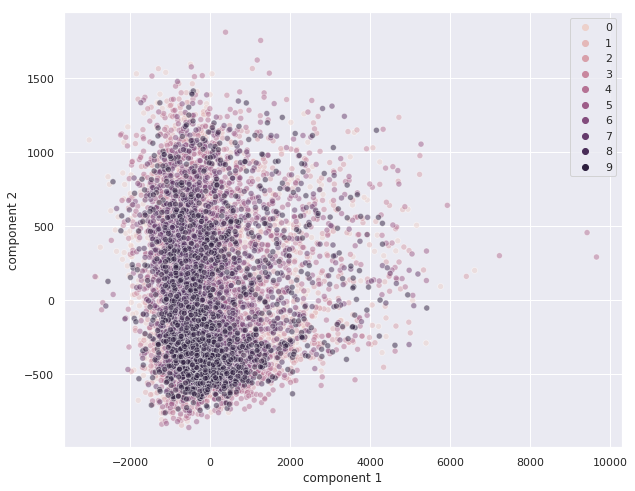

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler(with_std=False).fit_transform(X);  # standardization of data

ncomps = 2
pca = PCA(n_components=ncomps) # 10 to get 80% explained variance
Χ_final = pca.fit_transform(X_std)
print("EXPLAINED VARIANCE with {0:d} components: {1:.2f}".format(ncomps,pca.explained_variance_ratio_.sum()) )

plt.figure(figsize=(10,8))
sns.scatterplot(Χ_final[:,0], Χ_final[:,1], hue=y, alpha=0.5, legend='full')
plt.xlabel('component 1')
plt.ylabel('component 2')

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

ros = RandomUnderSampler(random_state=0)
ros.fit(X,y)
X, y = ros.fit_resample(X,y)
print('After undersampling: \n{}\n'.format(pd.DataFrame(y).iloc[:,0].value_counts()))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

classifier = xgboost.XGBClassifier(n_estimators=650, learning_rate=0.2, n_jobs=-1)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

ac = accuracy_score(y_test, y_pred)
#cv_ac = cross_val_score(classifier, X, y, cv=3, scoring='accuracy')
print("Name: %s, ac: %f" % ('XGBoost', ac))
#print("Name: %s, cv_ac: %f" % ('XGBoost', np.mean(cv_ac)))

After undersampling: 
7    1001
6    1001
5    1001
4    1001
3    1001
2    1001
9    1001
1    1001
8    1001
0    1001
Name: 0, dtype: int64



In [ ]:
filenames